#### GISC 420 T1 2022
# Lab assignment 4: Doing GIS with `geopandas`
Corvin Idler,  ID 300598312

# Assignment part containig given code


## Set things up and grab the data

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as pyplot
import geopandas
import pandas as pd
import numpy as np

In [2]:
pop = geopandas.read_file('data/welly-census-2013.gpkg')
rds = geopandas.read_file('data/welly-rds.gpkg')
crashes = geopandas.read_file('data/crashes-2017.gpkg')

## Take a look at the data
### First a map
Once again, a reminder of making maps in `geopandas`.

<AxesSubplot:title={'center':'General map of assignment materials'}>

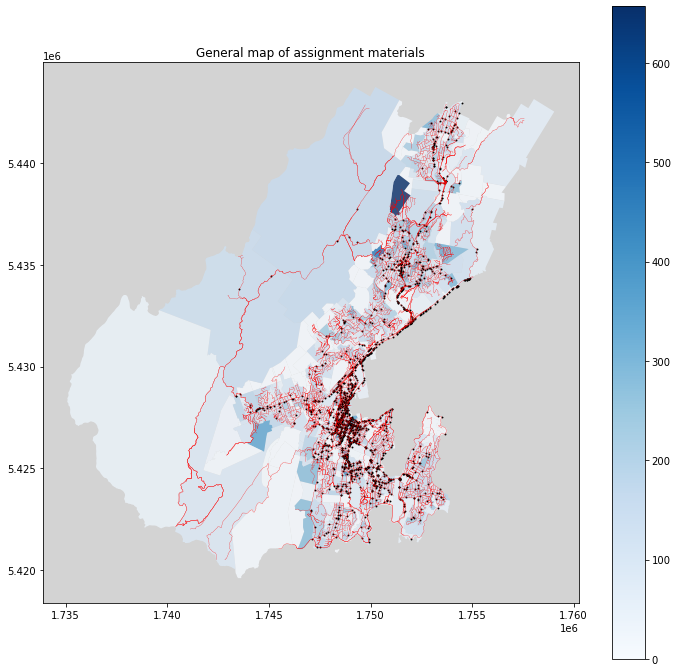

In [3]:
# Make the figure
fig = pyplot.figure(figsize=(12,12))
ax = fig.add_subplot(111)
# Set background colour to grey
ax.set_facecolor('lightgrey')
ax.set_title("General map of assignment materials")

# Plot meshblock populations
#line to visualize the meshblock boundaries... gets cluttered... but good to know.
#pop.plot(ax=ax, column='pop2013', cmap='Blues', edgecolor='green', linewidth=1, alpha=0.8, legend=True)
pop.plot(ax=ax, column='pop2013', cmap='Blues', alpha=0.8, legend=True)

# Add the roads
rds.plot(ax=ax, linewidth=0.25, color='r')
# Add the crashes
crashes.plot(ax=ax, color='k', markersize=.8)

### Then tables
Also important to examine the data tables, so that you know variable names and so on.

In [4]:
pop.head()

,OBJECTID,MB2013,AU2013,AU2013_NAM,pop2013,geometry
0,30221,1990400,572600,Tawa Central,57,"POLYGON ((1752715.127 5440817.178, 1752870.706..."
1,32856,2171003,576400,Newtown East,45,"POLYGON ((1749094.480 5424336.684, 1749100.024..."
2,32521,2142900,573400,Mt Victoria West,9,"POLYGON ((1749173.851 5426375.590, 1749190.606..."
3,32015,2104000,574702,Wilton,135,"POLYGON ((1747166.183 5429976.023, 1747153.031..."
4,32295,2124200,573000,Lambton,3,"POLYGON ((1748753.182 5428642.302, 1748818.498..."


In [5]:
rds.head()

,road_secti,length,geometry
0,1325758.0,11.687530,"MULTILINESTRING ((1748050.917 5431494.273, 174..."
1,1325784.0,307.427950,"MULTILINESTRING ((1751176.549 5434024.963, 175..."
2,1325809.0,153.915042,"MULTILINESTRING ((1753310.082 5439021.035, 175..."
3,1325810.0,157.631564,"MULTILINESTRING ((1753567.138 5438592.389, 175..."
4,1325811.0,15.048831,"MULTILINESTRING ((1753591.559 5439033.021, 175..."


In [6]:
crashes.head()

,CRASH_SEV,FATAL_COUN,SERIOUSINJ,MINORINJ_C,MULTI_VEH,CRASH_LOCN,CRASH_LO_1,geometry
0,F,1,0,0,Vehicle(s)+Pedestrian(s),MAIN ROAD,ESSEX ST,POINT (1753096.000 5440813.000)
1,M,0,0,1,Single vehicle,NASSAU AVENUE,JAMAICA DRIVE,POINT (1754055.000 5438847.000)
2,M,0,0,1,Vehicle(s)+Pedestrian(s),COBHAM DRIVE,SHELLY BAY ROAD,POINT (1751588.000 5424742.000)
3,M,0,0,1,Single vehicle,Z CARPARK,GOTHIC ST,POINT (1751402.000 5434774.000)
4,S,0,1,0,Single vehicle,THE TERRACE,ALLENBY TERRACE,POINT (1748404.000 5427737.000)


# Assignment part containig my code
## The assignment: a map of traffic accidents per km of road at Census Area Unit level


Let's do some cleanups and data reduction first. It is my understanding that Census Area Unit equals the column AU2013 (Area Unit 2013). 
c.f. https://rdrr.io/github/jmarshallnz/meshblocknz/man/mb2013.html
That means we can spatially dissolve all the meshblocks into the corresponding Area Units.

In [7]:
#drop the columns we don't need from the census dataset
pop.drop(["OBJECTID","MB2013"], axis=1, inplace=True)

#drop the columns we don't need from the crash dataset
crashes.drop(['CRASH_SEV', 'MULTI_VEH','CRASH_LOCN','CRASH_LO_1'], axis=1, inplace=True)

#turn the counts columns into numeric data type
crashes.loc[:, ("FATAL_COUN", "SERIOUSINJ","MINORINJ_C")] = crashes.loc[:, ("FATAL_COUN", "SERIOUSINJ","MINORINJ_C")].apply(pd.to_numeric)

#spatially dissolve all the mesh blocks into one single corresponding area unit
pop=pop.dissolve(by=['AU2013','AU2013_NAM'], aggfunc='sum', as_index=False)

Then let's do a spatial join between the census data set and the accident dataset to find all the accidents within the polygon of each area unit.
We then count the number of accidents and also (just out of curiosity) the number of injuries/fatalities.

In [8]:
#do a spacial join to "attach" each accident row to the Area Unit within which it is located
popcrash = geopandas.sjoin(crashes, pop, how='left', predicate='intersects')

#we get rid of the right hand side index as we don't need it
popcrash.drop('index_right', axis=1, inplace=True)

#now we "collapse" the rows... as we are actually only interested in the counts
#the assignement didn't ask for counting the number and types of injuries..
#but I'm a curious person... so I wanna know...
acc_counts=popcrash.groupby(['AU2013']).agg(
             FATAL_COUN=("FATAL_COUN", 'sum'),
             SERIOUSINJ=("SERIOUSINJ", 'sum'),
             MINORINJ_C=("MINORINJ_C", 'sum'),
             no_acc=("FATAL_COUN", 'count'))

In [9]:
#looking good
acc_counts

,FATAL_COUN,SERIOUSINJ,MINORINJ_C,no_acc
AU2013,,,,
572500,0,0,5,13
572600,1,0,9,24
572701,0,0,7,19
572702,0,0,2,6
572900,0,5,30,133
...,...,...,...,...
577400,0,0,0,1
577500,0,0,3,10
577601,0,2,4,8


Now merge the counting results with the original census dataframe, as the geometry got lost in the previous step and we want it back :)
Some NaN might be generated in rows where the Area Unit doesn't have any accidents (so during the merge there is nothing that matches).
We just replace these NaNs with 0

In [10]:
#merge dataframes (original census and counts) based on AU2013 ID
popcount=pd.merge(pop, acc_counts, on='AU2013', how='left')
popcount=popcount.fillna(0)

In [11]:
#looking good
popcount

,AU2013,AU2013_NAM,geometry,pop2013,FATAL_COUN,SERIOUSINJ,MINORINJ_C,no_acc
0,569302,Maungaraki,"POLYGON ((1756675.383 5438872.871, 1756728.891...",234,0.0,0.0,0.0,0.0
1,569402,Belmont,"MULTIPOLYGON (((1757994.238 5440852.687, 17580...",63,0.0,0.0,0.0,0.0
2,569800,Korokoro,"MULTIPOLYGON (((1755592.208 5434702.350, 17555...",93,0.0,0.0,0.0,0.0
3,570700,Elsdon-Takapuwahia,"POLYGON ((1751417.333 5443117.113, 1751400.417...",12,0.0,0.0,0.0,0.0
4,570800,Porirua Central,"MULTIPOLYGON (((1752045.890 5442068.408, 17520...",24,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
83,577601,Maupuia,"POLYGON ((1751965.533 5425249.340, 1751958.264...",1503,0.0,2.0,4.0,8.0
84,577602,Miramar West,"POLYGON ((1751689.052 5424975.482, 1751695.148...",399,0.0,0.0,0.0,5.0
85,577700,Makara-Ohariu,"POLYGON ((1746548.952 5425594.566, 1746526.988...",837,0.0,2.0,4.0,9.0
86,622101,Inlet-Wellington Harbour,"MULTIPOLYGON (((1753899.469 5423359.470, 17538...",0,0.0,0.0,0.0,0.0


Next we want to find all the roads in each census area unit. So we need to use the overlay function to calculate the intersection of all roads with all census area unit boundaries (polygons). We need to put the rds geopandas dataframe first, as the geometry type of the first frame will be preserved (lines).
We need this geometry type as we later on want to calculate the length of all the bits of road that are present in a census area unit. We also wanna make sure both datasets are in the same CRS.

In [12]:
#making sure the CRSs are aligned
rds=rds.to_crs(pop.crs)

#itersecting all roads on area unit boundaries.
rdspop = geopandas.overlay(rds,pop, how="intersection")

In [13]:
#looking good
rdspop

,road_secti,length,AU2013,AU2013_NAM,pop2013,geometry
0,1325758.0,11.687530,574402,Ngaio South,3135,"LINESTRING (1748055.919 5431491.735, 1748061.3..."
1,1081359.0,52.079062,574402,Ngaio South,3135,"LINESTRING (1748212.965 5431526.247, 1748209.7..."
2,1314716.0,55.503224,574402,Ngaio South,3135,"LINESTRING (1749334.983 5431918.007, 1749342.0..."
3,1314597.0,214.794951,574402,Ngaio South,3135,"LINESTRING (1749504.477 5431826.062, 1749585.6..."
4,1088821.0,99.336592,574402,Ngaio South,3135,"LINESTRING (1748730.426 5432255.024, 1748760.7..."
...,...,...,...,...,...,...
10650,1341985.0,143.849359,574703,Northland North,750,"LINESTRING (1747354.432 5429006.838, 1747361.5..."
10651,1343132.0,245.190192,574703,Northland North,750,"LINESTRING (1747356.902 5429434.721, 1747378.7..."
10652,1341979.0,58.961450,574703,Northland North,750,"LINESTRING (1747336.134 5429206.277, 1747329.0..."
10653,1341982.0,126.769809,574703,Northland North,750,"LINESTRING (1747297.629 5429332.374, 1747302.6..."


Now we need to recalculate the length of each road segment, because they were all clipped / intersected and the original length isn't valid anymore

In [14]:
#recalculate the length of the newly intersected road elements
rdspop['length'] = rdspop.length

In [15]:
#looking good
rdspop

,road_secti,length,AU2013,AU2013_NAM,pop2013,geometry
0,1325758.0,6.078160,574402,Ngaio South,3135,"LINESTRING (1748055.919 5431491.735, 1748061.3..."
1,1081359.0,52.079062,574402,Ngaio South,3135,"LINESTRING (1748212.965 5431526.247, 1748209.7..."
2,1314716.0,55.503224,574402,Ngaio South,3135,"LINESTRING (1749334.983 5431918.007, 1749342.0..."
3,1314597.0,113.651767,574402,Ngaio South,3135,"LINESTRING (1749504.477 5431826.062, 1749585.6..."
4,1088821.0,99.336592,574402,Ngaio South,3135,"LINESTRING (1748730.426 5432255.024, 1748760.7..."
...,...,...,...,...,...,...
10650,1341985.0,143.849359,574703,Northland North,750,"LINESTRING (1747354.432 5429006.838, 1747361.5..."
10651,1343132.0,245.190192,574703,Northland North,750,"LINESTRING (1747356.902 5429434.721, 1747378.7..."
10652,1341979.0,58.961450,574703,Northland North,750,"LINESTRING (1747336.134 5429206.277, 1747329.0..."
10653,1341982.0,100.228701,574703,Northland North,750,"LINESTRING (1747297.629 5429332.374, 1747302.6..."


And now we collapse the data frame to sum up the length of all road segments in each census area unit and convert it to km. The unit of the CRS is lucily already in meters (cf. output below or https://epsg.io/2193)

In [16]:
# cross checking the unit of measurement of the CRS is in meteres
rdspop.crs

<Derived Projected CRS: EPSG:2193>
Name: NZGD2000 / New Zealand Transverse Mercator 2000
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: New Zealand - North Island, South Island, Stewart Island - onshore.
- bounds: (166.37, -47.33, 178.63, -34.1)
Coordinate Operation:
- name: New Zealand Transverse Mercator 2000
- method: Transverse Mercator
Datum: New Zealand Geodetic Datum 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [17]:
#getting rid of columns we don't need
rdspop.drop('pop2013', axis=1, inplace=True)

#collapsing the data frame rows to have one single sum of road km per area unit 
rds_len=rdspop.groupby(['AU2013']).agg(
             length=("length", 'sum'))
rds_len.length=rds_len.length/1000.0

In [18]:
#looking good
rds_len

,length
AU2013,
572500,19.616080
572600,23.303676
572701,15.940470
572702,10.617321
572900,34.991838
...,...
577400,9.603352
577500,12.246722
577601,18.108513


Almost done... need to merge that back with the other data (geomery and accident numbers).

In [19]:
#merge the census area unit geometry + accident counts with the road km data
popcountroad=pd.merge(popcount, rds_len, on='AU2013', how='left')
popcountroad=popcountroad.fillna(0)

Now it's time to calculate the accidents per km metric. As the number of accidents as well as road length could be zero, we'll just have to fix cases of "divide by zero" and set them to 0 in the result column

In [20]:
popcountroad['acc_per_km']=popcountroad.no_acc/popcountroad['length']
popcountroad.loc[popcountroad.acc_per_km==np.inf,'acc_per_km']=0

Finally we have to make a pretty picture = choropleth map.

<AxesSubplot:title={'center':'Traffic accidents per km of road at Census Area Unit level'}>

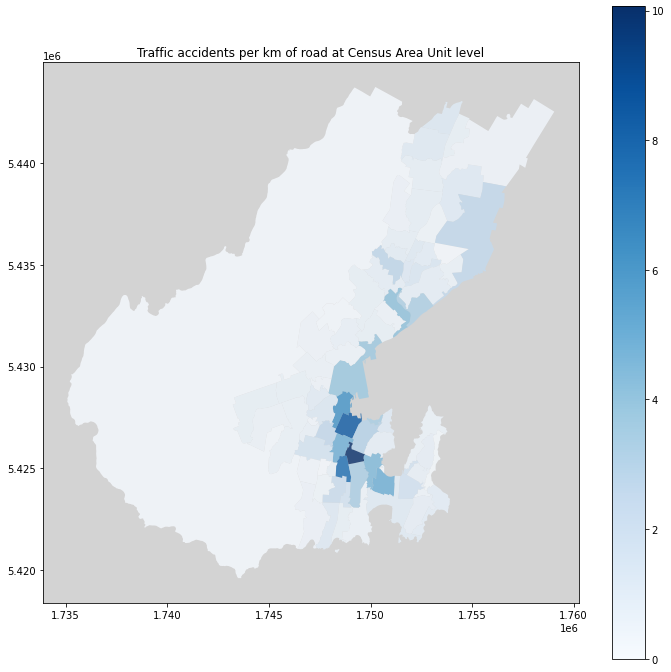

In [21]:
# Make the figure
fig = pyplot.figure(figsize=(12,12))
ax = fig.add_subplot(111)
# Set background colour to grey
ax.set_facecolor('lightgrey')
ax.set_title("Traffic accidents per km of road at Census Area Unit level")

popcountroad.plot(ax=ax, column='acc_per_km',  cmap='Blues', alpha=0.8, legend=True)

Hm... looks like Newtown is a bit of a hotspot.... Lets investigate just a tiny bit further. And plot the accidents back in

<AxesSubplot:title={'center':'Traffic accidents per km of road at Census Area Unit level'}>

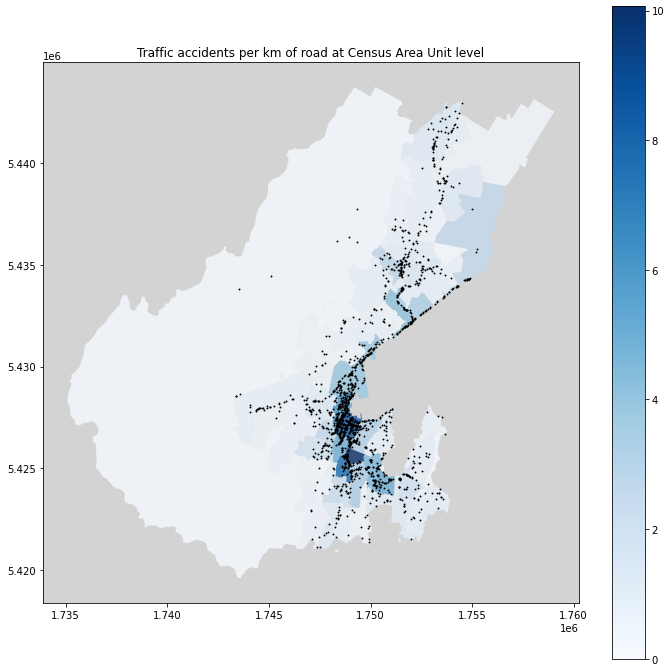

In [22]:
# Make the figure
fig = pyplot.figure(figsize=(12,12))
ax = fig.add_subplot(111)
# Set background colour to grey
ax.set_facecolor('lightgrey')
ax.set_title("Traffic accidents per km of road at Census Area Unit level")

popcountroad.plot(ax=ax, column='acc_per_km',  cmap='Blues', alpha=0.8, legend=True)
# Add the crashes
crashes.plot(ax=ax, color='k', markersize=.8)

Smells like trouble around Adelaide and Riddiford road... Maybe I just get the top 5 AU2013... because we can...

In [23]:
popcountroad.nlargest(5, 'acc_per_km')

,AU2013,AU2013_NAM,geometry,pop2013,FATAL_COUN,SERIOUSINJ,MINORINJ_C,no_acc,length,acc_per_km
68,576500,Adelaide,"POLYGON ((1748929.576 5425200.894, 1748916.578...",1017,0.0,2.0,8.0,34.0,3.378915,10.062401
13,573101,Willis Street-Cambridge Terrace,"POLYGON ((1748462.762 5426678.298, 1748391.493...",7338,0.0,11.0,23.0,208.0,24.799946,8.387115
65,576301,Newtown West,"POLYGON ((1748815.436 5424594.046, 1748779.860...",3141,0.0,2.0,15.0,50.0,6.622403,7.550130
12,573000,Lambton,"POLYGON ((1748184.844 5426997.336, 1748145.530...",5622,0.0,7.0,30.0,168.0,27.278498,6.158697
72,576901,Kilbirnie East,"POLYGON ((1750171.414 5423864.275, 1750147.043...",3213,0.0,2.0,16.0,68.0,13.754863,4.943706


Yep.... looks like Newtown and Adelaide are certainly a bit of a hot spot.. so is the Terrace and Lambton. 
All up that's not too surprising. Anybody that tries to go to work in the city from e.g. the eastern subbburbs knows that these are "choke points" 
with a lot of cars going through. So heaps of opportunities for accidents :)

Last but not least I'm just curious if the picture is different with regards to victims per km road.

In [24]:
popcountroad['all_victim']=(popcountroad.FATAL_COUN+popcountroad.SERIOUSINJ+popcountroad.MINORINJ_C)/popcountroad['length']

<AxesSubplot:title={'center':'Traffic accidents victims per km of road at Census Area Unit level'}>

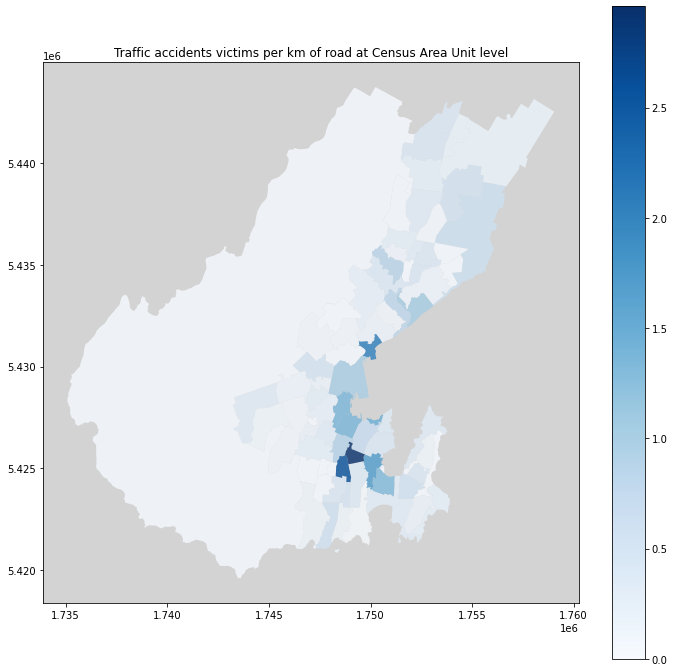

In [25]:
# Make the figure
fig = pyplot.figure(figsize=(12,12))
ax = fig.add_subplot(111)
# Set background colour to grey
ax.set_facecolor('lightgrey')
ax.set_title("Traffic accidents victims per km of road at Census Area Unit level")


popcountroad.plot(ax=ax, column='all_victim', cmap='Blues', alpha=0.8, legend=True)

In [26]:
popcountroad.nlargest(5, 'all_victim')

,AU2013,AU2013_NAM,geometry,pop2013,FATAL_COUN,SERIOUSINJ,MINORINJ_C,no_acc,length,acc_per_km,all_victim
68,576500,Adelaide,"POLYGON ((1748929.576 5425200.894, 1748916.578...",1017,0.0,2.0,8.0,34.0,3.378915,10.062401,2.959530
65,576301,Newtown West,"POLYGON ((1748815.436 5424594.046, 1748779.860...",3141,0.0,2.0,15.0,50.0,6.622403,7.550130,2.567044
42,574500,Kaiwharawhara,"POLYGON ((1750253.595 5430684.682, 1750253.595...",138,0.0,4.0,14.0,33.0,8.833963,3.735583,2.037591
73,576903,Kilbirnie West-Hataitai South,"POLYGON ((1749844.856 5424034.677, 1749827.124...",3198,0.0,2.0,15.0,45.0,9.967688,4.514587,1.705511
69,576600,Oriental Bay,"POLYGON ((1750394.078 5427233.253, 1750397.295...",1056,0.0,2.0,4.0,14.0,4.051241,3.455732,1.481028


Looks like Kaiwharawhara suddenly pops up in the top 5. Probably due to the motorway with higher speed the likelyhood for injuries are higher.


I'm sure one could analyse things further... but I leave it at that.
It was a fun assignement, hope the above code makes sense :)